In [42]:
import h5py
import matplotlib.pyplot as plt

In [43]:

import os

def find_file_with_id(root_dir='../results', file_id='74256'):
    """Find a file containing the given ID in the results directory structure"""
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if file_id in filename:
                # Return path relative to current directory
                return os.path.relpath(os.path.join(dirpath, filename))
    return None

file_path = find_file_with_id(file_id='74899')
print(file_path
      )
# Open the .h5 file in read mode
with h5py.File(file_path, 'r') as file:
    # Print the names of the groups/datasets in the file
    print("Keys in the file:", list(file.keys()))
    
    # Assuming there's a dataset named 'data' in the file
    # Modify this part according to your file's structure
    data = file['datasets']
    print(data.keys())

    rabi_t= data['phase'][:]
    pmt_count=data['pmt_counts_avg_thresholded'][:]

plt.figure(figsize=(4,3),dpi=300)
# Sort the data points by rabi_t
sort_idx = np.argsort(rabi_t)
rabi_t = rabi_t[sort_idx]
pmt_count = pmt_count[sort_idx]

# Calculate smoothed data using rolling average
window_size =40
smoothed_pmt = np.convolve(pmt_count, np.ones(window_size)/window_size, mode='valid')
smoothed_t = rabi_t[window_size-1:]

# plt.scatter(rabi_t, pmt_count)
plt.scatter(rabi_t, pmt_count,c='red',s=10)
plt.plot(smoothed_t, smoothed_pmt, color='blue', linewidth=2)
plt.xlabel('Phase')
plt.ylabel('<z>')
# Set custom x-axis ticks and labels
plt.xticks([0, 0.5, 1], ['0', '$\pi$', '$2\pi$'])



../results/2025-05-12/00/000074899-A7_Sync_VdP2_D1D2.h5
Keys in the file: ['archive', 'artiq_version', 'datasets', 'expid', 'rid', 'run_time', 'start_time']
<KeysViewHDF5 ['__param__VdP2mode', '__param__qubit', 'cal_count', 'cal_fit_signal', 'cal_freq', 'cal_motion_count', 'cal_motion_fit_signal', 'cal_motion_freq', 'cal_motion_pos', 'cal_pos', 'phase', 'pmt_counts', 'pmt_counts_avg_thresholded', 'pos']>


([<matplotlib.axis.XTick at 0x7cb2859d81c0>,
 [Text(0.0, 0, '0'), Text(0.5, 0, '$\\pi$'), Text(1.0, 0, '$2\\pi$')])

FFT estimated frequency: 91.770000 MHz
Fitted amplitude: 0.051906351971603634
Fitted frequency: 91.770000 MHz
Fitted phase: 0.0
Fitted offset: 0.438425


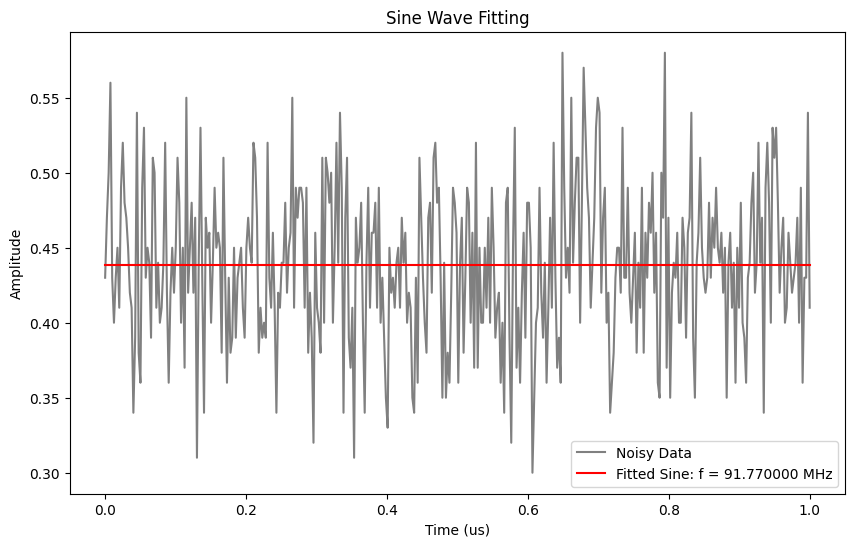

(np.float64(91770000.00000001),
 np.float64(0.051906351971603634),
 np.float64(0.0),
 np.float64(0.438425))

In [44]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

# Define the sine function
def sine_function(t, A, f, phi, C):
    return A * np.sin(2 * np.pi * f * t + phi) + C

# Function to estimate frequency using FFT and then perform a stable fit
def estimate_frequency_and_fit(t_data, y_data):
    # Step 1: Estimate the frequency using FFT
    N = len(t_data)  # Number of data points
    T = (t_data[1] - t_data[0]) * 1e-6  # Sample spacing in seconds (convert us to seconds)
    
    # Perform the FFT
    yf = fft(y_data - np.mean(y_data))  # Remove the mean to avoid DC bias
    xf = fftfreq(N, T)  # Frequency bins

    # Take the absolute value of the FFT result to get the magnitude spectrum
    magnitude_spectrum = np.abs(yf[:N//2])  # We only need the positive half of the spectrum
    xf = xf[:N//2]  # Only consider the positive frequencies

    # Find the peak in the magnitude spectrum (corresponding to the dominant frequency)
    peak_idx = np.argmax(magnitude_spectrum)
    estimated_frequency = np.abs(xf[peak_idx])  # Frequency in Hz
    
    # Step 2: Use curve fitting to refine the frequency and other parameters
    # Initial guess for the parameters A, f, phi, C
    initial_guess = [np.std(y_data), estimated_frequency, 0.0, np.mean(y_data)]

    # Perform curve fitting
    popt, pcov = curve_fit(sine_function, t_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    fitted_A, fitted_f, fitted_phi, fitted_C = popt

    # Print the results
    print(f"FFT estimated frequency: {estimated_frequency / 1e6:.6f} MHz")
    print(f"Fitted amplitude: {fitted_A}")
    print(f"Fitted frequency: {fitted_f / 1e6:.6f} MHz")
    print(f"Fitted phase: {fitted_phi}")
    print(f"Fitted offset: {fitted_C}")

    # Step 3: Plot the original data and the fitted sine wave
    plt.figure(figsize=(10, 6))
    plt.plot(t_data, y_data, label='Noisy Data', color='gray')
    plt.plot(t_data, sine_function(t_data, *popt), label=f'Fitted Sine: f = {fitted_f / 1e6:.6f} MHz', color='red')
    plt.legend()
    plt.xlabel('Time (us)')
    plt.ylabel('Amplitude')
    plt.title('Sine Wave Fitting')
    plt.show()

    return fitted_f, fitted_A, fitted_phi, fitted_C


# Call the function to estimate frequency and fit
estimate_frequency_and_fit(rabi_t, pmt_count)
